<a href="https://colab.research.google.com/github/KhaiNghiTranNguyen/AI-YOLO-CNN/blob/main/ki%E1%BB%83m_tra_ch%E1%BA%A5t_l%C6%B0%E1%BB%A3ng_th%C3%B9ng_h%C3%A0ng_xu%E1%BA%A5t_kho.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!unzip -q /content/sample_data/Box.zip -d /content/sample_data/Box
data = '/content/sample_data/Box'

In [ ]:
# 1. IMPORT & CÀI ĐẶT
import os, numpy as np, matplotlib.pyplot as plt
from PIL import Image

import tensorflow as tf
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D,
                                     BatchNormalization, Dropout,
                                     Flatten, Dense)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

# 2. LOAD DATA & TIỀN XỬ LÝ
data = '/content/sample_data/Box/Box'

IMG_SIZE = 128
images, labels, label_map = [], [], {}

# Lặp qua các thư mục con (mỗi thư mục = 1 lớp)
for idx, cls in enumerate(sorted(os.listdir(data))):
    cls_path = os.path.join(data, cls)
    if not os.path.isdir(cls_path):
        continue

    label_map[idx] = cls
    for f in os.listdir(cls_path):
        try:
            img = Image.open(os.path.join(cls_path, f)).convert('RGB')
            img = img.resize((IMG_SIZE, IMG_SIZE))
            images.append(np.asarray(img))
            labels.append(idx)
        except Exception as e:
            print('Lỗi khi đọc', f, ':', e)


# 3. TÁCH TRAIN / TEST SET

# Chuyển sang numpy & chuẩn hoá
X = np.array(images, dtype='float32') / 255.0
y = to_categorical(np.array(labels), num_classes=len(label_map))

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

print('Tổng ảnh:', X.shape[0])


Tổng ảnh: 194


In [20]:

# 4. DATA AUGMENTATION

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    brightness_range=[0.8, 1.2],
    horizontal_flip=True,
    fill_mode='nearest'
)
train_datagen.fit(X_train)

# 5. XÂY KIẾN TRÚC CNN CÓ BN + DROPOUT

def build_cnn(input_shape=(IMG_SIZE, IMG_SIZE, 3), n_classes=2):
    inputs = Input(shape=input_shape)

    x = Conv2D(32, (3,3), padding='same', activation='relu')(inputs)
    x = BatchNormalization()(x)
    x = Conv2D(32, (3,3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(2)(x)

    x = Conv2D(64, (3,3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = Conv2D(64, (3,3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(2)(x)

    x = Conv2D(128, (3,3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = Conv2D(128, (3,3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(2)(x)

    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)                 #  ← Dropout lớn giảm overfit
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.4)(x)

    outputs = Dense(n_classes, activation='softmax')(x)
    return Model(inputs, outputs)

model = build_cnn(n_classes=len(label_map))
model.summary()


# 6. COMPILE

optimizer = Adam(learning_rate=1e-4)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])


# 7. CALLBACKS: EARLY STOPPING & LR REDUCE

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=5, restore_best_weights=True)
lr_reduce = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.3, patience=3, min_lr=1e-6, verbose=1)

# 8. TRAIN

EPOCHS = 40
BATCH_SIZE = 32

history = model.fit(
    train_datagen.flow(X_train, y_train, batch_size=BATCH_SIZE),
    epochs=EPOCHS,
    validation_data=(X_test, y_test),
    callbacks=[early_stop, lr_reduce],
    verbose=2
)


# 9. ĐÁNH GIÁ

test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"✅ Test accuracy = {test_acc:.4f}")

model.save('box_classifier.keras')


Train: (155, 128, 128, 3)   Test: (39, 128, 128, 3)


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 128, 128, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │     8,388,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 2)              │           25

 Total params: 8,710,818 (33.23 MB)

 Trainable params: 8,709,922 (33.23 MB)

 Non-trainable params: 896 (3.50 KB)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/40
5/5 - 32s - 6s/step - accuracy: 0.5290 - loss: 1.3611 - val_accuracy: 0.4872 - val_loss: 0.6935 - learning_rate: 1.0000e-04
Epoch 2/40
5/5 - 23s - 5s/step - accuracy: 0.5355 - loss: 2.2380 - val_accuracy: 0.5128 - val_loss: 0.6944 - learning_rate: 1.0000e-04
Epoch 3/40
5/5 - 42s - 8s/step - accuracy: 0.5161 - loss: 2.1918 - val_accuracy: 0.4872 - val_loss: 0.6949 - learning_rate: 1.0000e-04
Epoch 4/40

Epoch 4: ReduceLROnPlateau reducing learning rate to 2.9999999242136255e-05.
5/5 - 25s - 5s/step - accuracy: 0.5355 - loss: 2.2904 - val_accuracy: 0.4872 - val_loss: 0.6950 - learning_rate: 1.0000e-04
Epoch 5/40
5/5 - 23s - 5s/step - accuracy: 0.4710 - loss: 3.5888 - val_accuracy: 0.4359 - val_loss: 0.6943 - learning_rate: 3.0000e-05
Epoch 6/40
5/5 - 25s - 5s/step - accuracy: 0.5226 - loss: 2.7413 - val_accuracy: 0.5128 - val_loss: 0.6931 - learning_rate: 3.0000e-05
Epoch 7/40
5/5 - 24s - 5s/step - accuracy: 0.5290 - loss: 2.4460 - val_accuracy: 0.5128 - val_loss: 0.6947 - lea

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


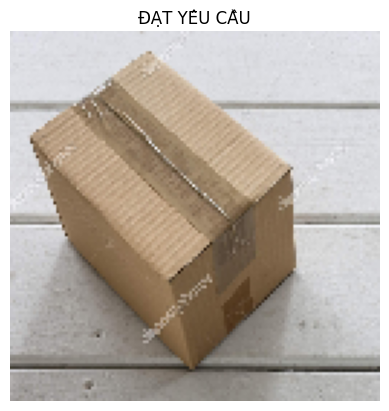

Tình trạng thùng: ĐẠT YÊU CẦU


In [13]:
import matplotlib.pyplot as plt
def predict_image(path):
    img = load_img(path, target_size=(IMG_SIZE,IMG_SIZE))
    arr = img_to_array(img)/255.0
    pred = model.predict(arr.reshape(1,IMG_SIZE,IMG_SIZE,3))
    cls = np.argmax(pred)
    plt.imshow(img); plt.axis('off'); plt.title(label_map[cls]); plt.show()
    print('Tình trạng thùng:', label_map[cls])

predict_image('/content/sample_data/14.jpg')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


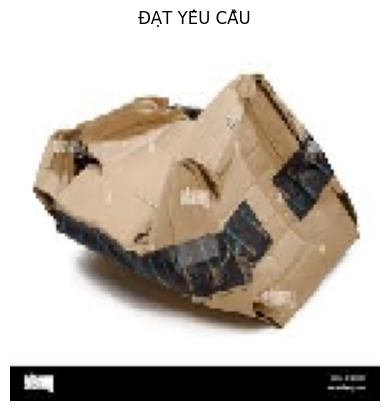

Tình trạng thùng: ĐẠT YÊU CẦU


In [18]:
import matplotlib.pyplot as plt
def predict_image(path):
    img = load_img(path, target_size=(IMG_SIZE,IMG_SIZE))
    arr = img_to_array(img)/255.0
    pred = model.predict(arr.reshape(1,IMG_SIZE,IMG_SIZE,3))
    cls = np.argmax(pred)
    plt.imshow(img); plt.axis('off'); plt.title(label_map[cls]); plt.show()
    print('Tình trạng thùng:', label_map[cls])

predict_image('/content/sample_data/16.jpg')